### Optimization for Computer Vision - Project
##### PDE constrained optimization problem for denoising and parameter estimation
Alexandre Boistard, 3A, SDI Paris-Saclay

##### A. Introduction
We will now reproduce the experiments of the selected paper. First, we write their framework.

##### A.1. Discretized framework

We discretize the interval $[0,T]$ into M (equal) subdomains, and we set $\Delta t = t_m - t_{m-1}$. The authors obtain the following semi-discretization:
$$
\begin{cases}
    \frac{X^{m+1} - X^m}{dt} + \nabla^2 (\lambda \nabla^2 X^m) + \nabla \cdot ((1 - \lambda) D(J_{\rho}^{\sigma} (\nabla X^m)) \nabla X^m) = 0, & \text{in } \Omega, \\
    \langle D(J_{\rho}^{\sigma} (\nabla X^m)) \nabla X^m, \nu \rangle = 0, & \text{on } \partial \Omega, \\
    X^m(x) = 0, & \text{on } \partial \Omega, \\
    X^0(x) = X_0(x), & \text{in } \Omega.
\end{cases}
$$

and for all $ m = M, \dots, 1 $:

$$
\begin{cases}
    -\frac{P^m - P^{m-1}}{dt} + \nabla^2 (\lambda \nabla^2 P^m) 
    - \nabla \cdot ((1 - \lambda) D(J_{\rho}^{\sigma} (\nabla X^m)) \nabla P^m) \\
    \quad + (1 - \lambda) D^*(J_{\rho}^{\sigma} (\nabla X^m)) \nabla X^m \nabla P^m = 0, & \text{in } \Omega, \\
    \langle D(J_{\rho}^{\sigma} (\nabla X^m)) \nabla P^m, \nu \rangle = 0, & \text{on } \partial \Omega, \\
    P^m(x) = 0, & \text{on } \partial \Omega, \\
    P^M(x) = W(x), & \text{in } \Omega.
\end{cases}
$$

The discretization of the gradient operator $ \nabla X = ((\nabla X)^1, (\nabla X)^2) $, knowing that $ X_{i,j} $, $ i, j = 1, \dots, (M_1, M_2) $ is the discrete image, and $ \mathbb{R}^{M_1 \times M_2} $ the set of discrete images:

$$
(\nabla X)^1_{i,j} =
\begin{cases}
    X_{i+1,j} - X_{i,j}, & \text{if } i < M_1, \\
    0, & \text{if } i = M_1.
\end{cases}
$$

$$
(\nabla X)^2_{i,j} =
\begin{cases}
    X_{i,j+1} - X_{i,j}, & \text{if } j < M_2, \\
    0, & \text{if } j = M_2.
\end{cases}
$$

We also need to define the discretization of the adjoint operator of the gradient, "div": $ (\mathbb{R}^{M_1 \times M_2})^2 \to \mathbb{R}^{M_1 \times M_2} $, satisfying the following relation:
$$
- \operatorname{div} Y \cdot X = Y \cdot \nabla X, \quad \forall X \in \mathbb{R}^{M_1 \times M_2}, \quad Y \in (\mathbb{R}^{M_1 \times M_2})^2.
$$

with:
$$
(\operatorname{div}(Y^1, Y^2))_{i,j} = (\operatorname{div}(Y^1, Y^2))^1_{i,j} + (\operatorname{div}(Y^1, Y^2))^2_{i,j},
$$
where: 
$
\operatorname{div}(Y^1, Y^2))^1_{i,j} =
\begin{cases}
    Y^1_{i,j} - Y^1_{i-1,j}, & \text{if } 1 < i < M_1, \\
    Y^1_{i,j}, & \text{if } i = 1, \\
    0, & \text{if } i = M_1.
\end{cases}
$ and $
(\operatorname{div}(Y^1, Y^2))^2_{i,j} =
\begin{cases}
    Y^2_{i,j} - Y^2_{i,j-1}, & \text{if } 1 < j < M_2, \\
    Y^2_{i,j}, & \text{if } j = 1, \\
    -Y^2_{i,j-1}, & \text{if } j = M_2.
\end{cases}
$

Plus, the matrix $ \nabla^2 $ can be interpreted as the kernel $ k_2 $ defined as:

$$
k_2 = k_{xx} + k_{yy} + 2k_{xy} =
\begin{pmatrix}
0 & 1 & 0 \\
1 & -2 & -1 \\
0 & -1 & 2
\end{pmatrix}.
$$

Therefore, the result of $ \nabla^2 $ is merely the convolution of $ X $ with the above linear kernel $ k_2 $. Moreover, the transpose of $ \nabla^2 $, denoted as $ \nabla^2* $, is given by the convolution with the rotated kernel $ \bar{k}_2 $.

For the approximation of $ D^*(J_{\rho}^{\sigma} (\nabla X)) = D'(J_{\rho}^{\sigma} (\nabla X)) (J_{\rho}^{\sigma} (\nabla X))' $, we use the following approximation:

$$
(J_{\rho}^{\sigma} (\nabla X_{i,j}))' =
\frac{J_{\rho}^{\sigma} (\nabla X_{i+1,j}) - J_{\rho}^{\sigma} (\nabla X_{i,j})}{X_{i+1,j} - X_{i,j}},
$$

or

$$
(J_{\rho}^{\sigma} (\nabla X_{i,j}))' =
\frac{J_{\rho}^{\sigma} (\nabla X_{i,j+1}) - J_{\rho}^{\sigma} (\nabla X_{i,j})}{X_{i,j+1} - X_{i,j}},
$$

for $ i, j = 1, \dots, (M_1 - 1, M_2 - 1) $.

---

##### A.2. Primal-Dual Algorithm
**Data:** Given a noisy image $ X_0 $, filtered image $ Y_0 $ and an initial parameter $ \lambda^0 $. Choose $ \rho, \epsilon, \sigma, \mu > 0 $, $ \alpha, T > 0 $, $ \delta_0 > 0 $, $ \eta_0 > 0 $, $ (k_1, k_2) \in \mathbb{R}^2 $ and initialization of variables $ \zeta^0 $.

**begin**  
$$
\lambda^{n+1} = (I + \eta_n \partial G)^{-1} (\lambda^n - \eta_n [S'(\lambda^n)]^* \zeta^n) \; \text{  // Use (14) for} $ (I + \eta_n \partial G)^{-1} $
$$


$$
\theta_n = \frac{1}{\sqrt{1+2\mu \delta_n}}, \quad \eta_{n+1} = \frac{\eta_n}{\theta_n} \quad \text{and} \quad \delta_{n+1} = \delta_n \theta_n.
$$

$$
\hat{\lambda}^{n+1} = \lambda^{n+1} + \theta_n (\lambda^{n+1} - \lambda^n)
$$

$$
X^{n+1}(T) = \mathcal{S}(\hat{\lambda}^{n+1}) \quad \text{// Computed from (9)}
$$

$$
\zeta^{n+1} = (I + \delta_{n+1} \partial F^*)^{-1} (\zeta^n + \delta_{n+1} \left(\frac{X^{n+1}(T) - Y_0}{\sqrt{\alpha} \sqrt{\lambda^n}} \right)) \; \text{  // Use (15) for} $ (I + \delta_{n+1} \partial F^*)^{-1} $
$$

Iterate until $ Err(\hat{\lambda}^{n+1}) < \epsilon $, where

$$
Err(\hat{\lambda}^{n+1}) = \frac{\|\mathcal{S}(\hat{\lambda}^{n+1}) - \mathcal{S}(\hat{\lambda}^n)\|_{L^2(\Omega)}}{\|\mathcal{S}(\hat{\lambda}^{n+1})\|_{L^2(\Omega)}}
$$

**Result:** The weighted parameter $ \hat{\lambda} $ and the restored image $ X $.




In [31]:
# Step 1: Import libraries and basic setup
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.restoration import denoise_bilateral
import numpy as np
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from tqdm import tqdm

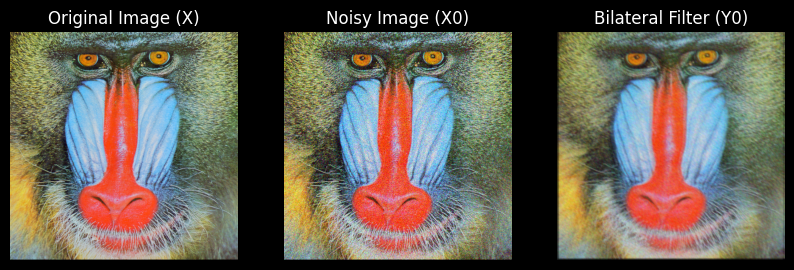

In [40]:
# Load the data
img = cv2.imread('baboon.png', cv2.IMREAD_COLOR).astype(np.float32)/255.0
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Add Gaussian noise (sigma = 30)
noise = np.random.normal(0, 30/255.0, img.shape)
noisy_img = np.clip(img + noise, 0, 1)

# Parameters for the bilateral filter (to be adjusted if needed)
sigma_color = 1.2   
sigma_spatial = 1.4   

# Apply bilateral filtering, preserving color channels
Y0 = denoise_bilateral(noisy_img, sigma_color=sigma_color, sigma_spatial=sigma_spatial, channel_axis=-1)

# Visualize
plt.style.use('dark_background') # to avoid some problems with my IDE
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(img) 
plt.title("Original Image (X)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(noisy_img)  
plt.title("Noisy Image (X0)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(Y0)
plt.title("Bilateral Filter (Y0)")
plt.axis('off')
plt.show()

In [33]:
# =============================================================================
# 1. Helper Functions for 2D Operators (single-channel)
# =============================================================================
laplacian_kernel = np.array([[0, 1, 0],
                             [1, -4, 1],
                             [0, 1, 0]], dtype=np.float32)
def laplacian_2d_single(img):
    return convolve2d(img, laplacian_kernel, mode='same', boundary='symm')
def gradient_2d_single(img):
    gx = np.zeros_like(img)
    gy = np.zeros_like(img)
    gx[:-1, :] = img[1:, :] - img[:-1, :]
    gy[:, :-1] = img[:, 1:] - img[:, :-1]
    return gx, gy
def divergence_2d_single(gx, gy):
    h, w = gx.shape
    div = np.zeros((h, w), dtype=gx.dtype)
    div[1:, :] += gx[1:, :] - gx[:-1, :]
    div[:, 1:] += gy[:, 1:] - gy[:, :-1]
    return div

# =============================================================================
# 2. Apply a 2D operator channel-by-channel
# =============================================================================
def apply_per_channel(func, img, *args, **kwargs):

    if img.ndim == 2:
        return func(img, *args, **kwargs)
    H, W, C = img.shape
    out = np.zeros_like(img)
    for c in range(C):
        out[..., c] = func(img[..., c], *args, **kwargs)
    return out

# =============================================================================
# 3. Structure Tensor and Diffusion Tensor for a Single Channel
# =============================================================================
def structure_tensor_single(img, sigma=1.0, rho=1.5):

    img_sigma = gaussian_filter(img, sigma=sigma)
    gx, gy = gradient_2d_single(img_sigma)
    J11 = gaussian_filter(gx*gx, sigma=rho)
    J12 = gaussian_filter(gx*gy, sigma=rho)
    J22 = gaussian_filter(gy*gy, sigma=rho)
    return J11, J12, J22
def diffusion_tensor_single(J11, J12, J22, k1=40, k2=40):

    trace = J11 + J22
    disc = (J11 - J22)**2 + 4*(J12**2)
    sqrt_disc = np.sqrt(disc + 1e-15)
    nu_plus  = 0.5*(trace + sqrt_disc)
    nu_minus = 0.5*(trace - sqrt_disc)
    angle_plus = 0.5 * np.arctan2(2*J12, (J11 - J22) + 1e-15)
    cplus = np.cos(angle_plus)
    splus = np.sin(angle_plus)
    phi_plus  = np.exp(- nu_plus  / k1)
    phi_minus = np.exp(- nu_minus / k2) * (1 - np.exp(- nu_plus / k1))
    D11 = phi_plus*(cplus**2) + phi_minus*(splus**2)
    D22 = phi_plus*(splus**2) + phi_minus*(cplus**2)
    D12 = (phi_plus - phi_minus)*cplus*splus
    return D11, D12, D22

# =============================================================================
# 4. Forward PDE Step (Single Channel)
#    Implements:
#    X_new 
# =============================================================================
def forward_pde_step_single(X, lam, dt, sigma=1.0, rho=1.5, k1=40, k2=40):
    # Fourth-order term: ∇²( lam ∇²X )
    lapX = laplacian_2d_single(X)
    lam_lapX = lam * lapX
    fourth_term = laplacian_2d_single(lam_lapX)
    # Anisotropic diffusion term: ∇·( (1-lam) D ∇X )
    J11, J12, J22 = structure_tensor_single(X, sigma, rho)
    D11, D12, D22 = diffusion_tensor_single(J11, J12, J22, k1, k2)
    gx, gy = gradient_2d_single(X)
    flux_x = D11*gx + D12*gy
    flux_y = D12*gx + D22*gy
    diffusion = divergence_2d_single(flux_x, flux_y)
    second_term = (1 - lam) * diffusion
    return X + dt * (-fourth_term + second_term)

# =============================================================================
# 5. Solve the Forward PDE for a Given lambda (Channel-by-Channel)
# =============================================================================
def solve_forward_pde(X0, lam, T, num_steps=50, sigma=1.0, rho=1.5, k1=40, k2=40):
    dt = T / num_steps
    # Process each channel independently
    def step_func(img):
        X = img.copy()
        for _ in range(num_steps):
            X = forward_pde_step_single(X, lam, dt, sigma, rho, k1, k2)
        return X
    if X0.ndim == 2:
        return step_func(X0)
    else:
        H, W, C = X0.shape
        X_final = np.zeros_like(X0)
        for c in range(C):
            X_final[..., c] = step_func(X0[..., c])
        return X_final

# =============================================================================
# 6. Adjoint PDE Step (Single Channel)
#    Implements:
#    P_new 
# =============================================================================
def adjoint_pde_step_single(P, X, lam, dt, sigma=1.0, rho=1.5, k1=40, k2=40):
    # Term 1: 
    lapP = laplacian_2d_single(P)
    lam_lapP = lam * lapP
    term1 = laplacian_2d_single(lam_lapP)
    # Term 2: 
    J11, J12, J22 = structure_tensor_single(X, sigma, rho)
    D11, D12, D22 = diffusion_tensor_single(J11, J12, J22, k1, k2)
    gxP, gyP = gradient_2d_single(P)
    fluxPx = D11*gxP + D12*gyP
    fluxPy = D12*gxP + D22*gyP
    term2 = - (1 - lam) * divergence_2d_single(fluxPx, fluxPy)
    # Term 3: 
    gxX, gyX = gradient_2d_single(X)
    dot_grad = gxX*gxP + gyX*gyP
    D_star_scale = 0.05  # chosen constant (tune if needed)
    term3 = (1 - lam) * D_star_scale * dot_grad
    RHS = term1 + term2 + term3
    return P - dt * RHS

# =============================================================================
# 7. Solve the Adjoint PDE for a Given lambda
#    Terminal condition: P(T)= zeta 
# =============================================================================
def solve_adjoint_pde(X, lam, zeta, T, num_steps=50, sigma=1.0, rho=1.5, k1=40, k2=40):
    dt = T / num_steps
    def step_func(P_init, X_channel):
        P = P_init.copy()
        for _ in range(num_steps):
            P = adjoint_pde_step_single(P, X_channel, lam, dt, sigma, rho, k1, k2)
        return P
    if X.ndim == 2:
        return step_func(zeta, X)
    else:
        H, W, C = X.shape
        P_final = np.zeros_like(X)
        for c in range(C):
            P_final[..., c] = step_func(zeta[..., c], X[..., c])
        return P_final

# =============================================================================
# 8. Proximal Operators for Primal-Dual Updates
# =============================================================================
def prox_G(lam, lam_min=1e-3, lam_max=0.99):
    return np.clip(lam, lam_min, lam_max)
def prox_F_star(z1_bar, z2_bar, delta):

    z1_new = np.clip(z1_bar, -1, 1)
    z2_new = z2_bar / (1 + delta)
    return z1_new, z2_new

# =============================================================================
# 9. Accelerated Primal-Dual Algorithm 
# =============================================================================
def accelerated_primal_dual_denoising(X0, params):
  
    # Unpack parameters
    alpha    = params.get('alpha', 0.1)
    k1_param = params.get('k1', 40)
    k2_param = params.get('k2', 40)
    rho      = params.get('rho', 1.5)
    sigma    = params.get('sigma', 1.0)
    T        = params.get('T', 1.0)
    max_iter = params.get('max_iter', 200)
    tol      = params.get('tol', 1e-5)
    sigma_d  = params.get('sigma_d', sigma_spatial)
    sigma_r  = params.get('sigma_r', sigma_color)
    
    # Ensure image is float and has shape (H,W,C)
    if X0.ndim == 2:
        X0 = X0[..., None]
    H, W, C = X0.shape
    
    # Build filtered image Y0 via bilateral filter (channel-by-channel)
    Y0 = np.zeros_like(X0)
    for c in range(C):
        Y0[..., c] = cv2.bilateralFilter((X0[..., c]*255).astype(np.uint8),
                                          d=9, sigmaColor=sigma_r*255,
                                          sigmaSpace=sigma_d)
        Y0[..., c] = Y0[..., c].astype(np.float32)/255.0
    
    # Initialize lmabda (primal variable) and dual variables zeta=(z1, z2)
    lam = np.full((H, W), 8e-3, dtype=np.float32)
    # For fidelity, we store z1 per channel (H,W,C)
    z1 = np.zeros((H, W, C), dtype=np.float32)
    # For gradient dual, we store a 2-field (x,y) per pixel (H,W,2)
    z2 = np.zeros((H, W, 2), dtype=np.float32)
    
    # Step sizes and acceleration parameters
    eta   = 0.1
    delta = 0.1
    mu    = 0.01
    theta = 1.0
    
    # Define helper: solve PDE per channel
    def solve_pde_channels(X_init, lam_):
        out = np.zeros_like(X_init)
        for c in range(X_init.shape[2]):
            out[..., c] = solve_forward_pde(X_init[..., c], lam_, T, num_steps=50,
                                             sigma=sigma, rho=rho, k1=k1_param, k2=k2_param)
        return out

    # Similarly, solve adjoint per channel (for fidelity part z1)
    def solve_adjoint_channels(X_T, lam_, zT):
        out = np.zeros_like(X_T)
        for c in range(X_T.shape[2]):
            out[..., c] = solve_adjoint_pde(X_T[..., c], lam_, zT[..., c], T, num_steps=50,
                                             sigma=sigma, rho=rho, k1=k1_param, k2=k2_param)
        return out

    # initial forward solution S(lam) using current lam
    X_lam_hat = solve_pde_channels(X0, lam)
    
    for n in tqdm(range(max_iter), desc="Processing"):
        lam_old = lam.copy()
        z1_old  = z1.copy()
        z2_old  = z2.copy()
        
        # (1) Primal update: lam^(n+1) = prox_G ( lam^n - eta [S'(lam^n)]^* zeta^n )
        # Compute forward solution
        X_T = solve_pde_channels(X0, lam)
        # Solve adjoint PDE with terminal condition z1 (fidelity part)
        P0 = solve_adjoint_channels(X_T, lam, z1)
        # Compute sensitivity; here we approximate by summing over channels
        grad_lam = - np.sum(apply_per_channel(laplacian_2d_single, X_T) *
                           apply_per_channel(laplacian_2d_single, P0), axis=-1)
        lam_bar = lam - eta * grad_lam
        lam_new = prox_G(lam_bar, 1e-3, 0.99)
        
        # (2) Acceleration: theta_n = 1/sqrt(1+2*mu*delta)
        theta_n = 1.0 / np.sqrt(1.0 + 2.0*mu*delta)
        # (3) Update step-sizes:
        eta_new = eta / theta_n
        delta_new = delta * theta_n
        # (4) Extrapolation: lam_hat = lam_new + theta_n*(lam_new - lam)
        lam_hat = lam_new + theta_n*(lam_new - lam)
        
        # (5) Forward solve with extrapolated λ: X^(n+1)(T) = S(lam_hat)
        X_lam_hat_new = solve_pde_channels(X0, lam_hat)
        
        # (6) Dual update:
        # Update fidelity dual: z1_bar = z1 + delta_new*(X_lam_hat_new - Y0)
        z1_bar = z1 + delta_new * (X_lam_hat_new - Y0)
        # Update gradient dual: use gradient of lam_hat (2D)
        gx, gy = gradient_2d_single(lam_hat)
        z2_bar = z2 + delta_new * np.sqrt(alpha) * np.stack([gx, gy], axis=-1)
        z1_new, z2_new = prox_F_star(z1_bar, z2_bar, delta_new)
        
        # (7) Stopping criterion: relative change in forward solution
        if n > 0 and n < max_iter:
                    err = np.linalg.norm(X_lam_hat_new - X_lam_hat) / (np.linalg.norm(X_lam_hat_new) + 1e-12)
                    if err < tol:
                        print(f"Converged at iteration {n} with error={err:.2e}")
                        lam = lam_hat
                        X_lam_hat = X_lam_hat_new
                        z1 = z1_new
                        z2 = z2_new
                        break
        elif n == max_iter:
            print(f"Reached max iterations {max_iter}")
            lam = lam_hat
            X_lam_hat = X_lam_hat_new
            z1 = z1_new
            z2 = z2_new
        # Update variables for next iteration
        lam = lam_new
        z1 = z1_new
        z2 = z2_new
        eta = eta_new
        delta = delta_new
        X_lam_hat = X_lam_hat_new

    return X_lam_hat, lam

In [34]:
# =============================================================================
# 10. Wrapping up of the method
# =============================================================================
def PDE_method(filename='barbara.png',n_iter=5,add_gaussian_noise=True):
    # Load color image (BGR -> convert to RGB)
    img = cv2.imread(filename, cv2.IMREAD_COLOR).astype(np.float32)/255.0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Add Gaussian noise (sigma = 30)
    noise = np.random.normal(0, 30/255.0, img.shape)
    if not add_gaussian_noise:
        noise = 0
        
    noisy_img = np.clip(img + noise, 0, 1)
    
    Y0 = denoise_bilateral(noisy_img, sigma_color=sigma_color, sigma_spatial=sigma_spatial, channel_axis=-1)
    # Define parameters
    params = {
        'alpha': 0.1,
        'k1': 35,
        'k2': 35,
        'rho': 1.5,
        'sigma': 1.0,
        'T': 1.0,
        'max_iter': n_iter, # chosen pretty small for high computational needs
        'tol': 1e-5,
        'sigma_d': sigma_spatial,
        'sigma_r': sigma_color
    }
    
    X_restored, lambda_opt = accelerated_primal_dual_denoising(noisy_img, params)
        
    # Create a figure with a 2x3 layout
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # Increased size for clarity
    
    # Plot each image in the corresponding subplot
    axes[0, 0].imshow(np.clip(img, 0, 1))
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(np.clip(noisy_img, 0, 1))
    axes[0, 1].set_title('Noisy')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(np.clip(Y0, 0, 1))
    axes[1, 0].set_title('Bilateral filter')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(np.clip(X_restored, 0, 1))
    axes[1, 1].set_title('Restored')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(lambda_opt, cmap='viridis')
    axes[1, 2].set_title('Spatial λ')
    axes[1, 2].axis('off')
    
    # Hide the empty subplot (top-right)
    axes[0, 2].axis('off')
    
    # Adjust layout to avoid overlapping
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Set dark background for readability
    plt.style.use('dark_background')
    
    # Show the figure
    plt.show()

    #PSNR and SSIM 
    psnr_value = peak_signal_noise_ratio(img, X_restored, data_range=1.0)
    ssim_value = structural_similarity(img, X_restored, data_range=1.0, channel_axis=-1)

    print("PSNR: " + str(psnr_value))
    print("SSIM: " + str(ssim_value))


Processing: 100%|██████████| 100/100 [1:14:03<00:00, 44.44s/it]


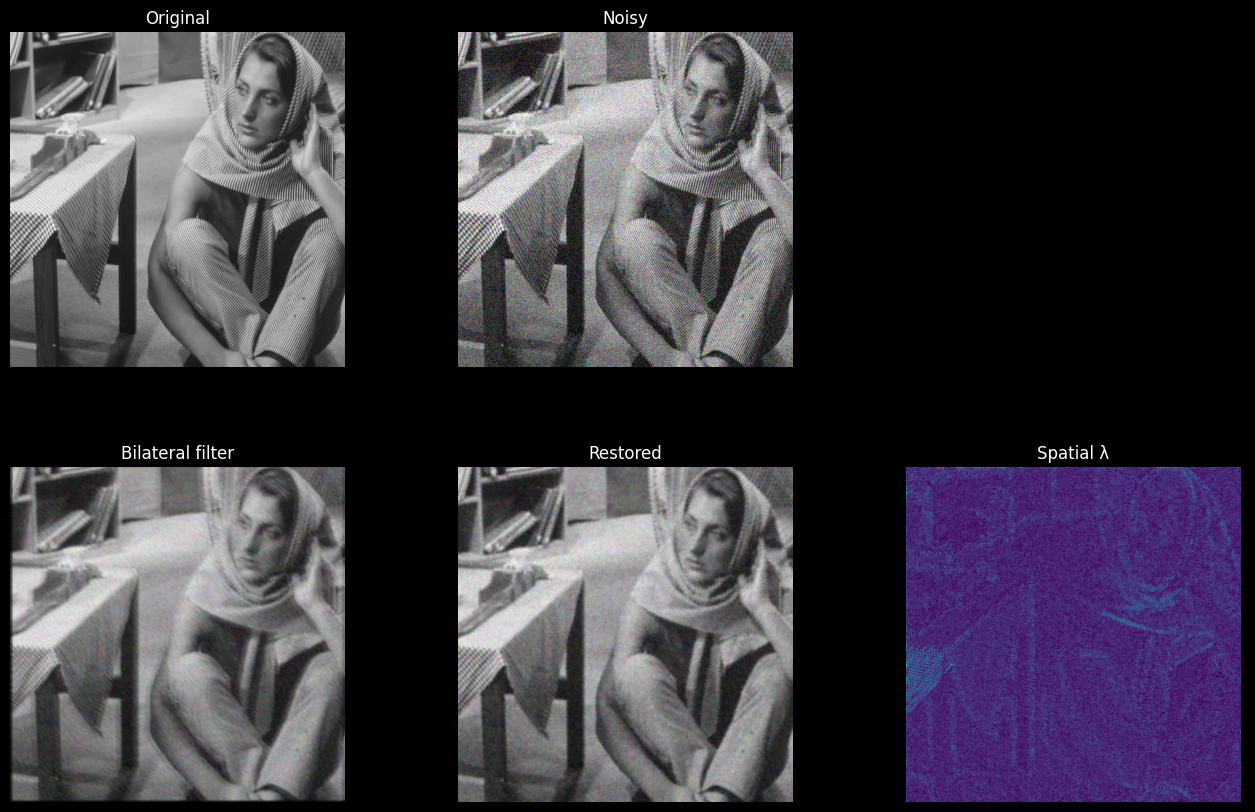

PSNR: 23.745521103022714
SSIM: 0.62225467


In [35]:
# =============================================================================
# 11. Run on Example (Barbara, present in the paper)
# =============================================================================
filename = 'barbara.png'
PDE_method(filename,n_iter=100)

Processing: 100%|██████████| 100/100 [1:42:02<00:00, 61.23s/it]


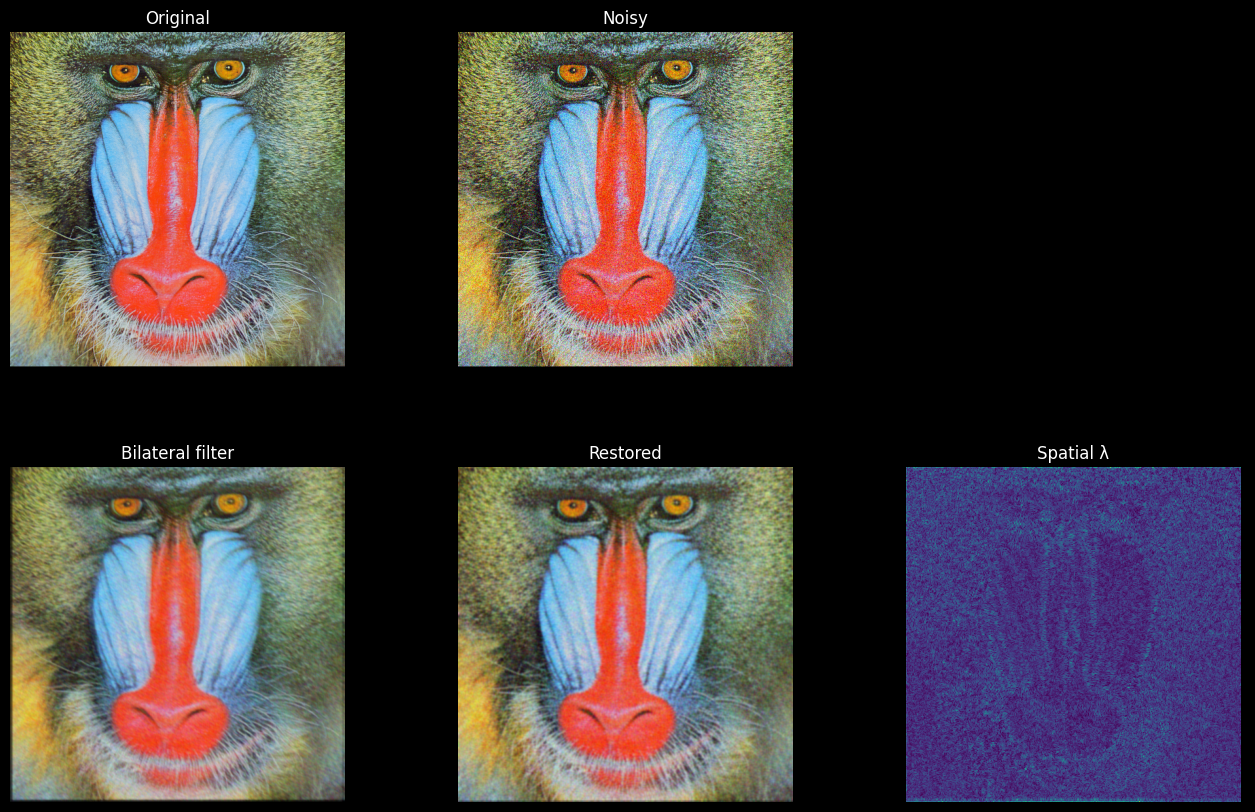

PSNR: 21.539217973418857
SSIM: 0.5596575


In [36]:
# =============================================================================
# 11. Run on Example (Baboon, not present in the paper but classical in 
# denoising, see ESRGAN for instance)
# =============================================================================
filename = 'baboon.png'
PDE_method(filename,n_iter=100)

Processing: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


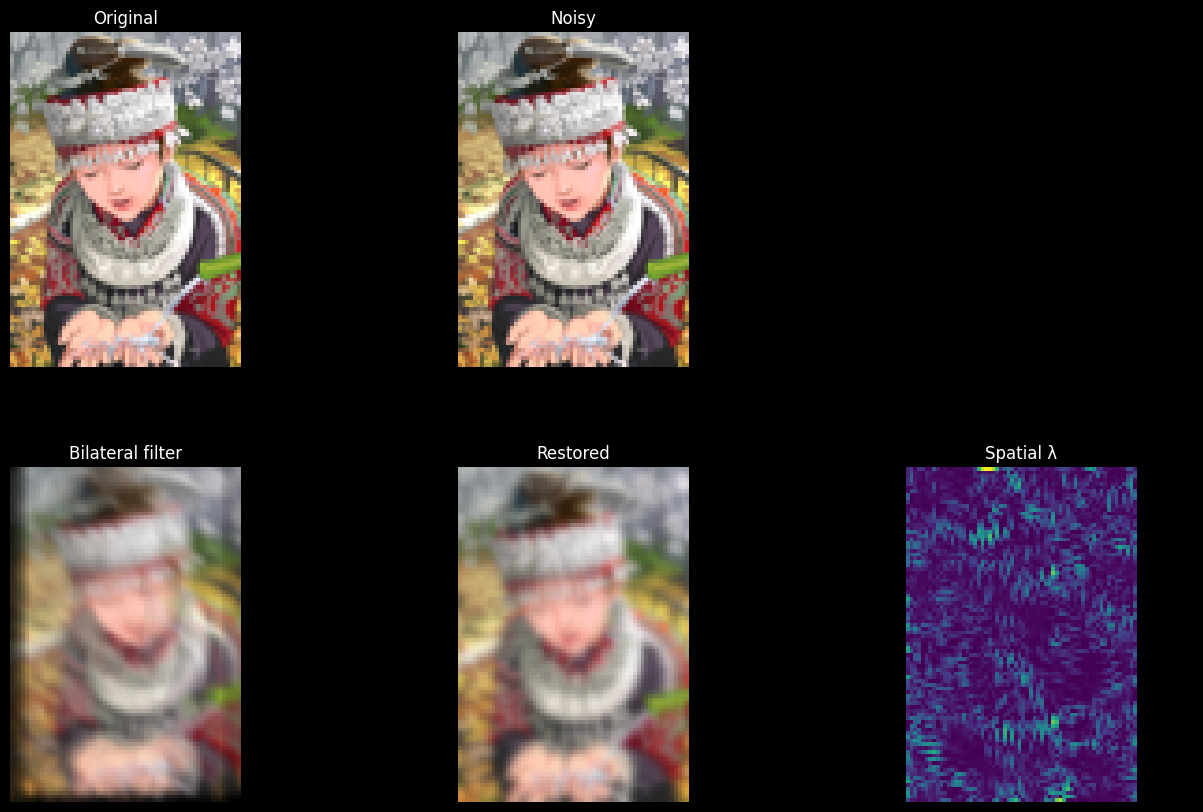

PSNR: 20.575415248527484
SSIM: 0.7317279


In [37]:
# =============================================================================
# 11. Run on Example (Comic, noise is coming from low resolution rather than 
# gaussian
# Let's see if the model is relevant in this case - where it should not be)
# =============================================================================
filename = 'comic.png'
PDE_method(filename,n_iter=50,add_gaussian_noise=False)